In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import shap
import pickle

shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Read Dataset

,No,Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
0,6.0,99.950000,0.895,4.0,6,184.490000,42.640000,19.250000,1
1,27.0,65.770000,0.894,4.0,6,179.250000,80.300000,21.000000,1
2,21.0,73.540000,0.900,4.0,6,176.630000,92.270000,20.750000,1
3,107.0,50.350000,0.969,4.0,7,172.020000,18.150000,18.625000,1
4,NaN,48.865201,0.939,NaN,5,211.624175,17.546100,22.623871,1
...,...,...,...,...,...,...,...,...,...
102,NaN,57.845846,0.958,NaN,5,168.468421,22.109954,17.017225,0
103,121.0,81.860000,0.967,4.0,7,137.000000,23.980000,17.125000,0
104,NaN,54.480048,0.940,NaN,6,98.542340,28.999338,12.628784,0
105,NaN,56.987053,0.959,NaN,5,169.178946,21.489349,13.258302,0


(107, 9)
1    54
0    53
Name: Class, dtype: int64


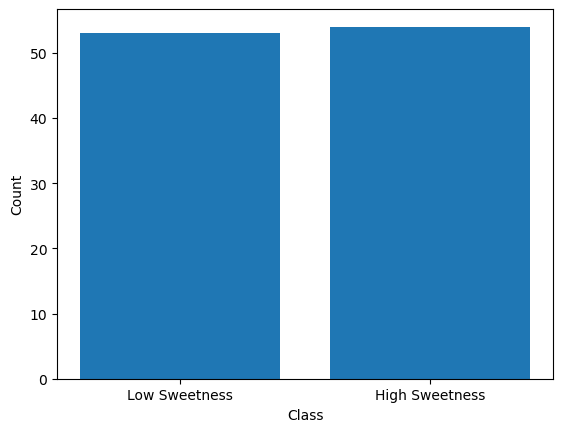

In [2]:
dataset = 'Dataset.xlsx'
sheet_name = 'GoodDataset'
export_good_bad_dataset = False
outlier_removal = False

if dataset == 'Dataset.xlsx':
    num = 0
    df = pd.read_excel(f'Dataset/{dataset}', sheet_name=sheet_name)
else:
    file = dataset.split('-')[0]
    num = dataset.split('-')[1].split('.')[0]
    df = pd.read_csv(f'Dataset/{dataset}')

# with pd.option_context('display.max_rows', 6): display(df)

display(df)

print(df.shape)

class_count = df['Class'].value_counts()
print(class_count)

plt.bar(['Low Sweetness', 'High Sweetness'], [class_count[0], class_count[1]])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Fill NaN with Mean

In [3]:
roundness_mean = df['Roundness'].mean()
max_frequency_mean = df['Max Frequency (Hz)'].mean()

print(f'Roundness Mean: {roundness_mean}')
print(f'Max Frequency (Hz) Mean: {max_frequency_mean}')

df['Roundness'].fillna(roundness_mean, inplace=True)
df['Max Frequency (Hz)'].fillna(max_frequency_mean, inplace=True)

Roundness Mean: 0.9465073088904865
Max Frequency (Hz) Mean: 128.0575718334945


# Features and Target Selection

In [4]:
feature = ['Weight (g)', 'Roundness', 'Lower Petal', 'Max Frequency (Hz)', 'Max Magnitude']
X = df[feature]
y = df['Class']

## Normalize the Dataset

In [5]:
standard_scaler = StandardScaler()
X_ss = standard_scaler.fit_transform(df[feature])
pickle.dump(standard_scaler, open('Dataset/normalized_dataset.dataset', 'wb'))

# Dataset Visualization

## Pearson Correlation

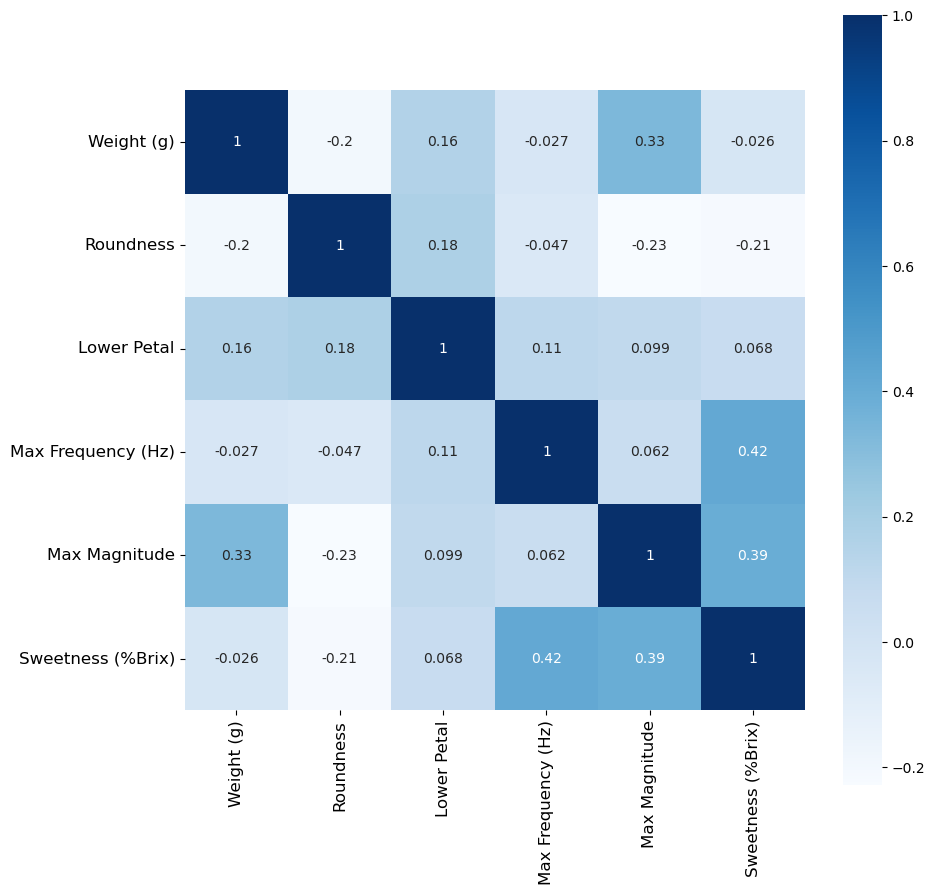

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[feature + ['Sweetness (%Brix)']].corr(), cmap="Blues", square=True, annot=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('pearson_correlation.pdf', dpi=600,bbox_inches='tight') 
plt.savefig('pearson_correlation.png', dpi=600, bbox_inches='tight')

plt.show() 

## T-SNE

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 107 samples in 0.000s...
[t-SNE] Computed neighbors for 107 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 107 / 107
[t-SNE] Mean sigma: 0.419562
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.310616
[t-SNE] KL divergence after 1000 iterations: 0.464034


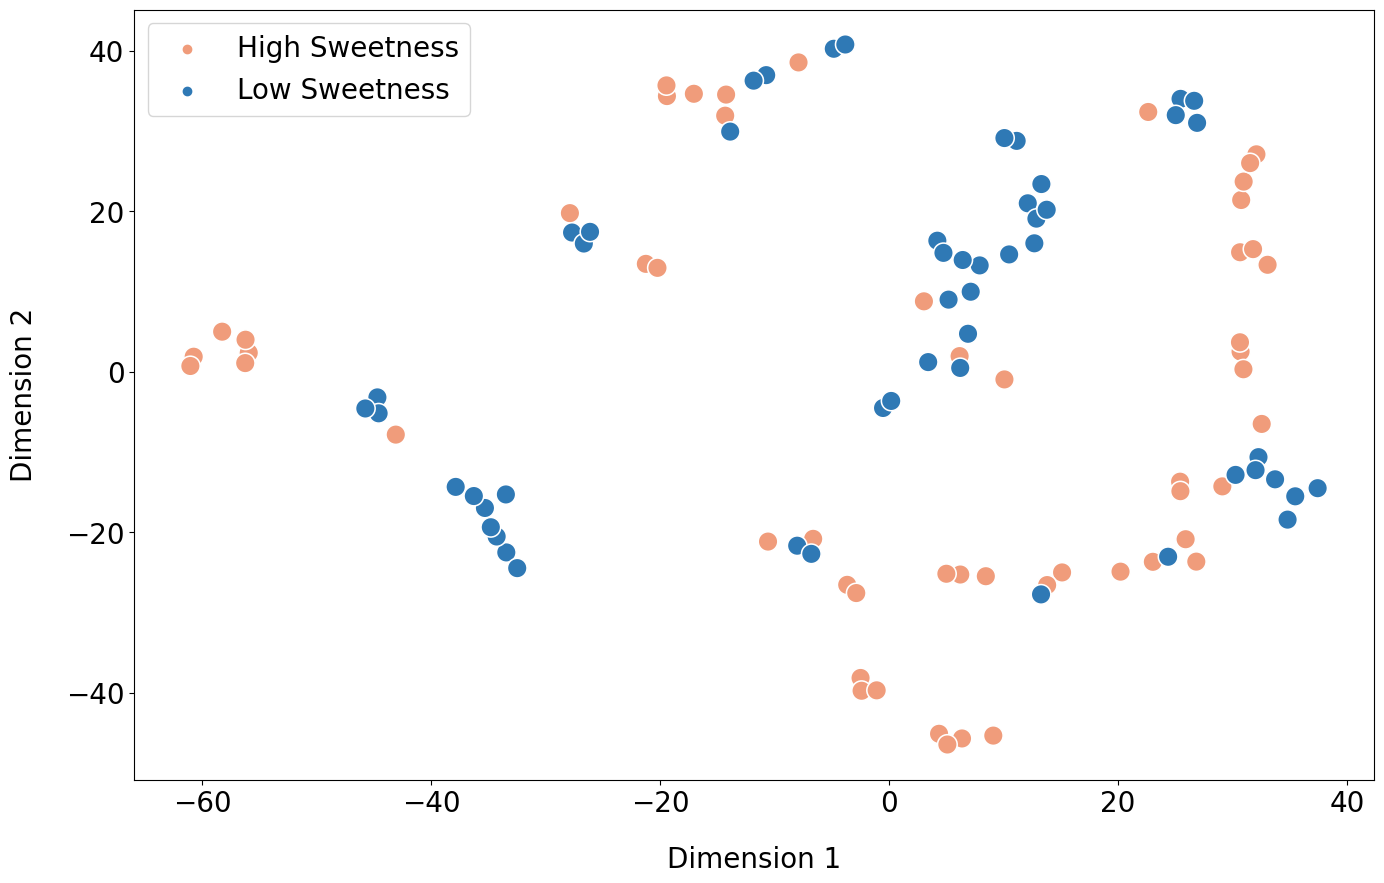

In [7]:
X_normalized = StandardScaler().fit_transform(X)

X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random',
                  verbose=1,
                  perplexity=3, 
                  random_state=42).fit_transform(X_normalized)

df_tsne = pd.DataFrame({'Dimension 1': X_embedded[:, 0],
                        'Dimension 2': X_embedded[:, 1],
                        'Class': y})

# pd.cut(df['Sweetness (%Brix)'],
#                                         bins=[0, 18, 999],
#                                         labels=['Low Sweetness', 'High Sweetness'],
#                                         right=False)

df_tsne['Class'] = ['High Sweetness' if i == 1 else 'Low Sweetness' for i in df_tsne['Class']]

palette = [sns.color_palette('RdBu')[1], sns.color_palette('RdBu')[-1]]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=df_tsne,
    x='Dimension 1', 
    y='Dimension 2',
    palette=palette,
    hue='Class',
    s=200,
    legend="full",
)
plt.xlabel('Dimension 1', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.ylabel('Dimension 2', fontsize=20, labelpad=20)
plt.yticks(fontsize=20)

plt.legend(loc='best', fontsize=20)

plt.savefig('t_sne.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('t_sne.png', dpi=600, bbox_inches='tight')

plt.show()

## Boxplot

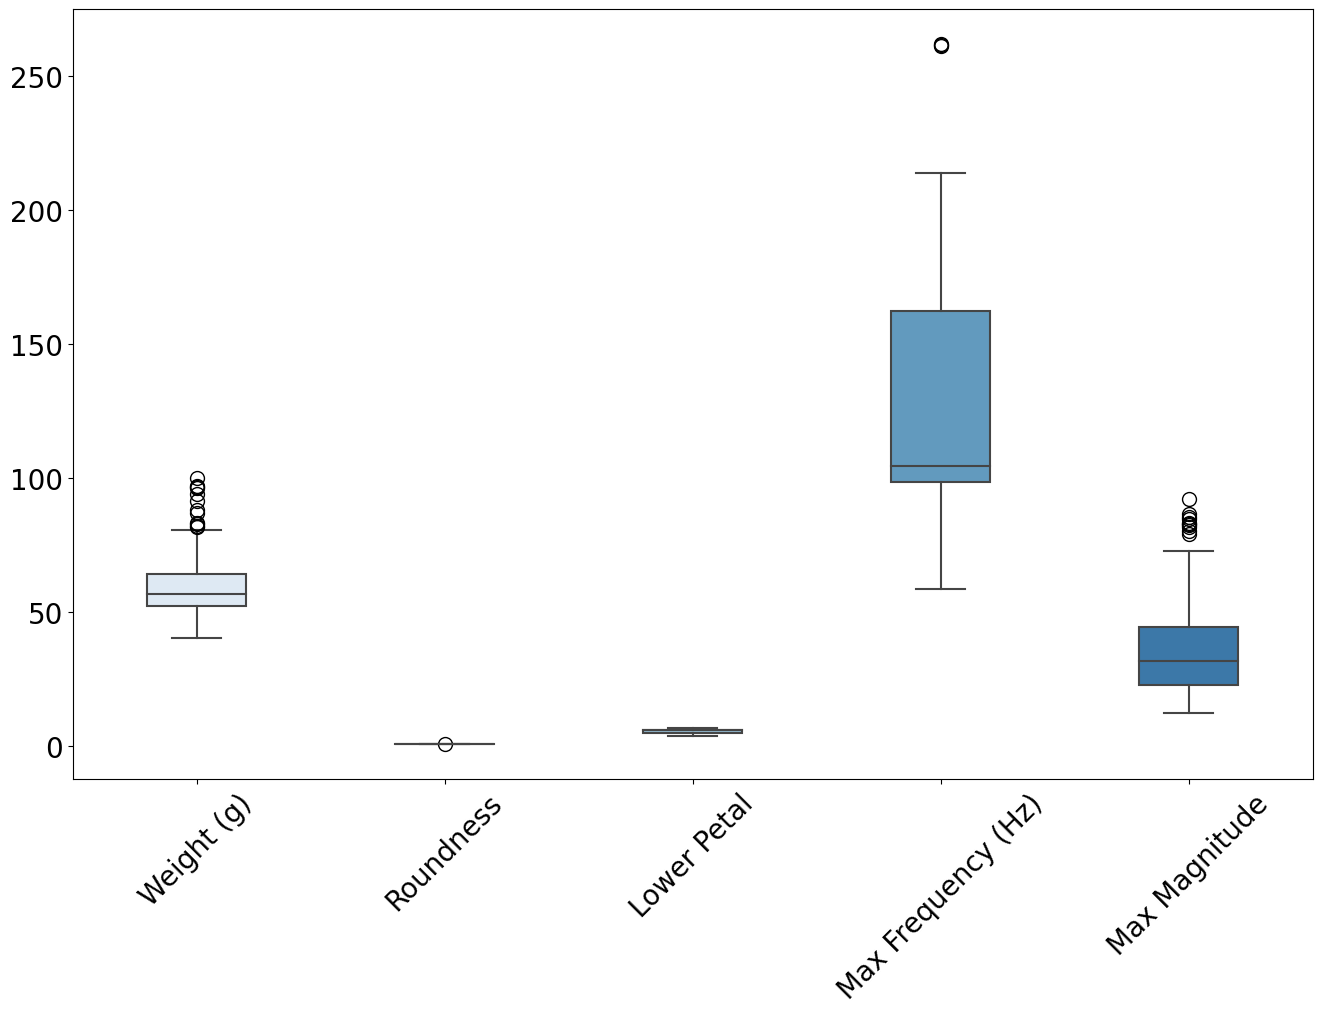

In [8]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=X, 
            palette=sns.color_palette('Blues'),
            width=0.4,
            flierprops={'marker': 'o', 
                        'markersize': 10, 
                        'markerfacecolor': 'None', 
                        'markeredgecolor': 'black'})

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.savefig('box_plot.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('box_plot.png', dpi=600, bbox_inches='tight')

plt.show()

# IQR

In [9]:
def remove_outlier(_df, column):
    Q1, Q3 = _df[column].quantile(0.25), _df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    no_outlier = _df[(_df[column] > lower_limit) & (_df[column] < upper_limit)]
    
    return no_outlier

In [10]:
df_no_outlier = remove_outlier(df, 'Weight (g)')
df_no_outlier = remove_outlier(df_no_outlier, 'Roundness')
df_no_outlier = remove_outlier(df_no_outlier, 'Max Frequency (Hz)')
df_no_outlier = remove_outlier(df_no_outlier, 'Max Magnitude')

display(df_no_outlier)

,No,Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
3,107.0,50.350000,0.969,4.0,7,172.020000,18.150000,18.625000,1
4,NaN,48.865201,0.939,NaN,5,211.624175,17.546100,22.623871,1
5,NaN,46.294660,0.925,NaN,5,104.463849,45.273911,18.163731,1
6,NaN,45.687172,0.980,NaN,6,210.310411,20.137329,20.447451,1
7,117.0,46.690000,0.935,4.0,6,130.276327,18.860000,18.000000,1
...,...,...,...,...,...,...,...,...,...
100,NaN,61.750255,0.954,NaN,5,74.875753,12.728426,17.184458,0
102,NaN,57.845846,0.958,NaN,5,168.468421,22.109954,17.017225,0
104,NaN,54.480048,0.940,NaN,6,98.542340,28.999338,12.628784,0
105,NaN,56.987053,0.959,NaN,5,169.178946,21.489349,13.258302,0


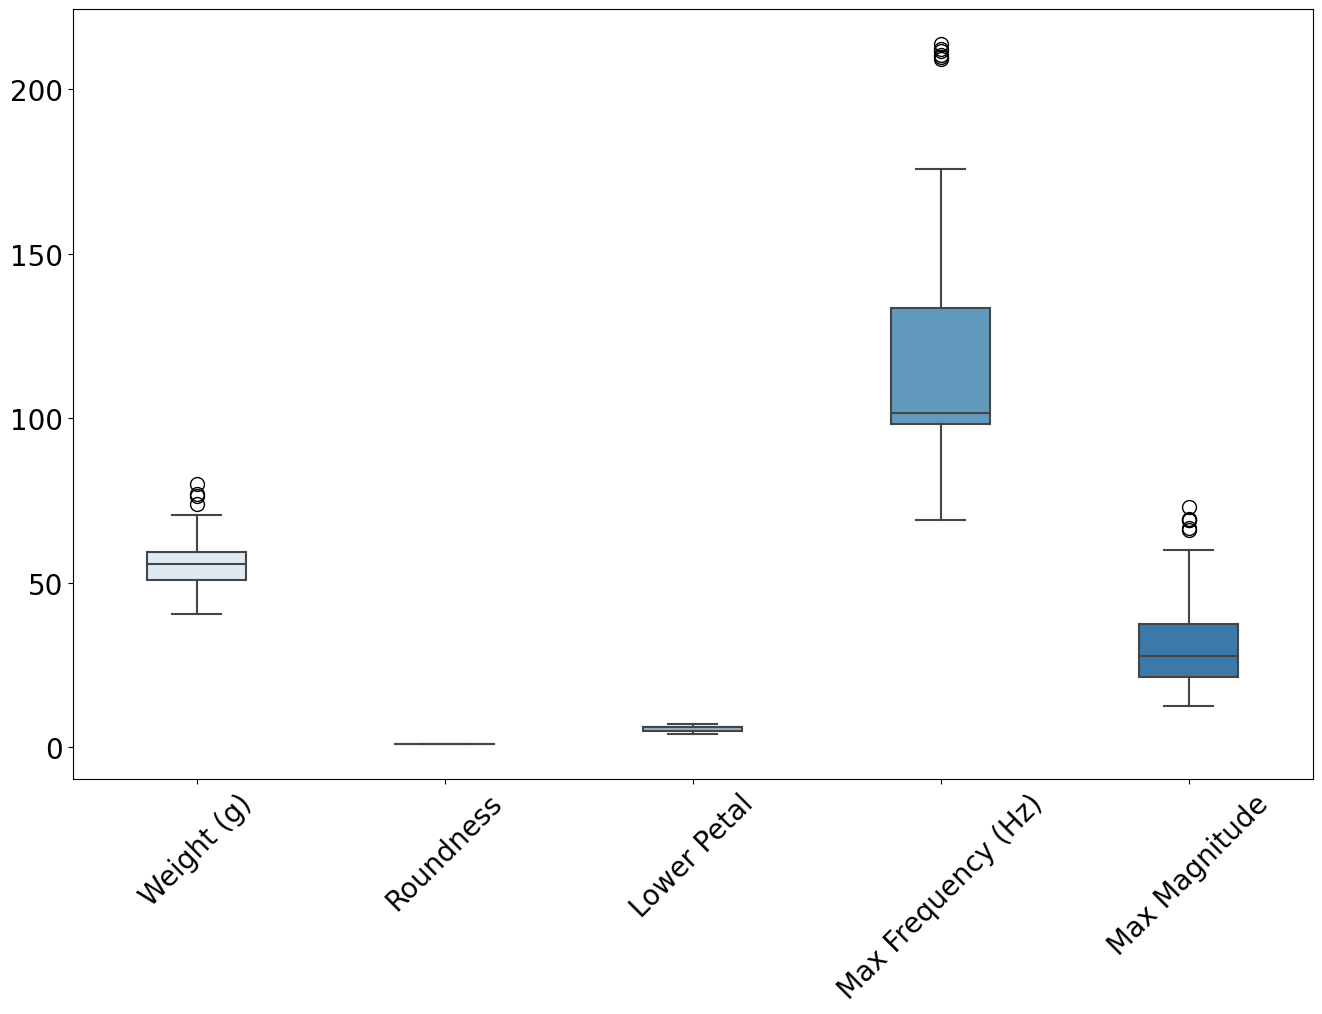

In [11]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_no_outlier[feature], 
            palette=sns.color_palette('Blues'),
            width=0.4,
            flierprops={'marker': 'o', 
                        'markersize': 10, 
                        'markerfacecolor': 'None', 
                        'markeredgecolor': 'black'})

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.show()

In [12]:
if outlier_removal:
    X = df_no_outlier[feature]
    y = df_no_outlier['Class']

# Hyperparameter

In [13]:
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

score = {
    'auc': 'roc_auc',
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

## KNN

In [14]:
standard_scaler = StandardScaler()

KNN = KNeighborsClassifier(n_jobs=-1)
KNN_parameter = {
    'model__leaf_size': list(range(1, 15)),
    'model__n_neighbors': list(range(1, 10, 2)),
    'model__p': np.arange(1.0, 3.0, 0.4),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', KNN)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=KNN_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0,
                           return_train_score=True)
grid_search.fit(X, y)

print('KNN Best Estimator: ', grid_search.best_estimator_)
print('KNN Best Parameter: ', grid_search.best_params_)
print('KNN Best Score: ', grid_search.best_score_)

KNN Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=3,
                                      p=2.5999999999999996,
                                      weights='distance'))])
KNN Best Parameter:  {'model__algorithm': 'auto', 'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__p': 2.5999999999999996, 'model__weights': 'distance'}
KNN Best Score:  0.86


In [15]:
KNN = grid_search.best_estimator_['model']
KNN

KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=3,
                     p=2.5999999999999996, weights='distance')

## SVM

In [16]:
standard_scaler = StandardScaler()

SVM = SVC(probability=True)
SVM_parameter = [
    {'model__kernel': ['linear'], 
     'model__C': np.arange(1.0, 3.0, 0.2)},
    {'model__kernel': ['rbf'], 
     'model__C': np.arange(1.0, 3.0, 0.2), 
     'model__gamma': list(range(1, 10))}
]

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', SVM)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=SVM_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('SVM Best Estimator: ', grid_search.best_estimator_)
print('SVM Best Parameter: ', grid_search.best_params_)
print('SVM Best Score: ', grid_search.best_score_)

SVM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', SVC(gamma=1, probability=True))])
SVM Best Parameter:  {'model__C': 1.0, 'model__gamma': 1, 'model__kernel': 'rbf'}
SVM Best Score:  0.8699999999999999


In [17]:
SVM = grid_search.best_estimator_['model']
SVM

SVC(gamma=1, probability=True)

## Logistic Regression

In [18]:
standard_scaler = StandardScaler()

LR = LogisticRegression()
LR_parameter = [
    {'model__solver': ['newton-cg', 'lbfgs', 'sag'], 
     'model__penalty': ['l2']},
    {'model__solver': ['liblinear'], 
     'model__penalty': ['l1', 'l2']},
    {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', LR)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=LR_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Logistic Regression Best Estimator: ', grid_search.best_estimator_)
print('Logistic Regression Best Parameter: ', grid_search.best_params_)
print('Logistic Regression Best Score: ', grid_search.best_score_)

Logistic Regression Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01))])
Logistic Regression Best Parameter:  {'model__C': 0.01}
Logistic Regression Best Score:  0.7672727272727273


In [19]:
LR = grid_search.best_estimator_['model']
LR

LogisticRegression(C=0.01)

## Decision Tree

In [20]:
standard_scaler = StandardScaler()

DT = DecisionTreeClassifier(criterion='entropy', random_state=42)
DT_parameter = {
    'model__max_depth': list(range(1, 15)),
    'model__max_leaf_nodes': list(range(2, 15))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', DT)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=DT_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Decision Tree Best Estimator: ', grid_search.best_estimator_)
print('Decision Tree Best Parameter: ', grid_search.best_params_)
print('Decision Tree Best Score: ', grid_search.best_score_)

Decision Tree Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_leaf_nodes=5, random_state=42))])
Decision Tree Best Parameter:  {'model__max_depth': 4, 'model__max_leaf_nodes': 5}
Decision Tree Best Score:  0.9181818181818183


In [21]:
DT = grid_search.best_estimator_['model']
DT

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=5,
                       random_state=42)

## XGBoost

In [22]:
standard_scaler = StandardScaler()

XGB = XGBClassifier(learning_rate=0.02, objective='binary:logistic', nthread=1)
XGB_parameter = {
    'model__min_child_weight': list(range(1, 5)),
    'model__gamma': list(range(1, 3)),
    'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__n_estimators': [500, 1000],
    'model__max_depth': list(range(1, 5))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', XGB)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=XGB_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('XGBoost Best Estimator: ', grid_search.best_estimator_)
print('XGBoost Best Parameter: ', grid_search.best_params_)
print('XGBoost Best Score: ', grid_search.best_score_)

XGBoost Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=500, n_jobs=None

In [23]:
XGB = grid_search.best_estimator_['model']
XGB

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

## LightGBM

In [24]:
standard_scaler = StandardScaler()

LGBM = LGBMClassifier(learning_rate=0.02, objective='binary', n_jobs=-1, random_state=42)
LGBM_parameter = {
    'model__num_leaves': list(range(2, 5)),
    'model__max_depth': list(range(1, 4)),
    'model__n_estimators': [500, 1000],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', LGBM)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=LGBM_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('LightGBM Best Estimator: ', grid_search.best_estimator_)
print('LightGBM Best Parameter: ', grid_search.best_params_)
print('LightGBM Best Score: ', grid_search.best_score_)

LightGBM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6, learning_rate=0.02,
                                max_depth=1, n_estimators=500, num_leaves=2,
                                objective='binary', random_state=42))])
LightGBM Best Parameter:  {'model__colsample_bytree': 0.6, 'model__max_depth': 1, 'model__n_estimators': 500, 'model__num_leaves': 2}
LightGBM Best Score:  0.9181818181818182


In [25]:
LGBM = grid_search.best_estimator_['model']
LGBM

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.02, max_depth=1,
               n_estimators=500, num_leaves=2, objective='binary',
               random_state=42)

## Artificial Neural Network

In [26]:
standard_scaler = StandardScaler()

ANN = MLPClassifier(max_iter=100000, random_state=42)
ANN_parameter = {
    'model__hidden_layer_sizes': [(2, 2), (3, 4), (4, 2), (4, 4)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['lbfgs', 'sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', ANN)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=ANN_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('Artificial Neural Network Best Estimator: ', grid_search.best_estimator_)
print('Artificial Neural Network Best Parameter: ', grid_search.best_params_)
print('Artificial Neural Network Best Score: ', grid_search.best_score_)

Artificial Neural Network Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(4, 4),
                               max_iter=100000, random_state=42,
                               solver='lbfgs'))])
Artificial Neural Network Best Parameter:  {'model__activation': 'logistic', 'model__hidden_layer_sizes': (4, 4), 'model__learning_rate': 'constant', 'model__solver': 'lbfgs'}
Artificial Neural Network Best Score:  0.850909090909091


In [27]:
ANN = grid_search.best_estimator_['model']
ANN

MLPClassifier(activation='logistic', hidden_layer_sizes=(4, 4), max_iter=100000,
              random_state=42, solver='lbfgs')

## Random Forest

In [28]:
standard_scaler = StandardScaler()

RF = RandomForestClassifier(criterion='gini', random_state=42)
RF_parameter = {
    'model__n_estimators': list(range(1, 30)),
    'model__max_depth': list(range(1, 15)),
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', RF)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=RF_parameter, 
                           cv=cross_validation, 
                           scoring=score, 
                           refit='accuracy',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Random Forest Best Estimator: ', grid_search.best_estimator_)
print('Random Forest Best Parameter: ', grid_search.best_params_)
print('Random Forest Best Score: ', grid_search.best_score_)

Random Forest Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=3, n_estimators=11,
                                        random_state=42))])
Random Forest Best Parameter:  {'model__max_depth': 3, 'model__n_estimators': 11}
Random Forest Best Score:  0.9272727272727274


In [29]:
RF = grid_search.best_estimator_['model']
RF

RandomForestClassifier(max_depth=3, n_estimators=11, random_state=42)

## Voting Classifier

In [30]:
estimator = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('LR', LR),
    ('DT', DT),
    ('XGB', XGB),
    ('LGBM', LGBM),
    ('ANN', ANN),
    ('RF', RF)
]
VC = VotingClassifier(estimator, 
                      weights=[0.15, 0.1, 0.05, 0.1, 0.3, 0.1, 0.1, 0.1], 
                      voting='soft', 
                      n_jobs=-1)
VC

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(leaf_size=1, n_jobs=-1,
                                                   n_neighbors=3,
                                                   p=2.5999999999999996,
                                                   weights='distance')),
                             ('SVM', SVC(gamma=1, probability=True)),
                             ('LR', LogisticRegression(C=0.01)),
                             ('DT',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     max_leaf_nodes=5,
                                                     random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=No...
                                             learning_rate=0.02, max_depth=1,
                                             n_estimators=500, num_leaves=2,
                                             objective='binary',
                                             random_state=42)),
                             ('ANN',
                              MLPClassifier(activation='logistic',
                                            hidden_layer_sizes=(4, 4),
                                            max_iter=100000, random_state=42,
                                            solver='lbfgs')),
                             ('RF',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=11,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft',
                 weights=[0.15, 0.1, 0.05, 0.1, 0.3, 0.1, 0.1, 0.1])

# Train the Model

In [31]:
initial_model_name = {
    'KNN': 'KNN',
    'SVM': 'SVM',
    'LR': 'Logistic Regression',
    'DT': 'Decision Tree',
    'XGB': 'XGBoost',
    'LGBM': 'LightGBM',
    'ANN': 'ANN',
    'RF': 'Random Forest',
    'VC': 'Voting Classifier'
}

In [42]:
model_y_true = {
    'index': [],
    'no': [],
    'value': []
}

model_y_predict = {
    'KNN': [],
    'SVM': [],
    'LR': [],
    'DT': [],
    'XGB': [],
    'LGBM': [],
    'ANN': [],
    'RF': [],
    'VC': []
}

model_y_predict_score = {
    'KNN': [],
    'SVM': [],
    'LR': [],
    'DT': [],
    'XGB': [],
    'LGBM': [],
    'ANN': [],
    'RF': [],
    'VC': []
}

classifier = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('LR', LR),
    ('DT', DT),
    ('XGB', XGB),
    ('LGBM', LGBM),
    ('ANN', ANN),
    ('RF', RF),
    ('VC', VC)
]

for train_index, test_index in cross_validation.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model_y_true['index'] = np.append(model_y_true['index'], test_index)
    model_y_true['no'] = np.append(model_y_true['no'], df.iloc[test_index, 0])
    model_y_true['value'] = np.append(model_y_true['value'], y_test)

    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test)

    for initial, model in classifier:
        model.fit(X_train, y_train)
        pickle.dump(model, open(f'Model/{initial}.model', 'wb'))
        y_predict = model.predict(X_test)
        y_predict_score = model.predict_proba(X_test)
        model_y_predict[initial] = np.append(model_y_predict[initial], y_predict)
        model_y_predict_score[initial] = np.append(model_y_predict_score[initial], y_predict_score[:, 1])

# Evaluate the Model

## Accuracy, Precision, Recall, and F1 Score

,Model,Accuracy,Precision,Recall,F1
0,KNN,85.981308,93.333333,77.777778,84.848485
0,SVM,86.915888,85.714286,88.888889,87.272727
0,Logistic Regression,76.635514,80.851064,70.370370,75.247525
0,Decision Tree,91.588785,94.117647,88.888889,91.428571
0,XGBoost,91.588785,92.452830,90.740741,91.588785
0,LightGBM,91.588785,90.909091,92.592593,91.743119
0,ANN,85.046729,86.538462,83.333333,84.905660
0,Random Forest,92.523364,96.000000,88.888889,92.307692
0,Voting Classifier,91.588785,94.117647,88.888889,91.428571


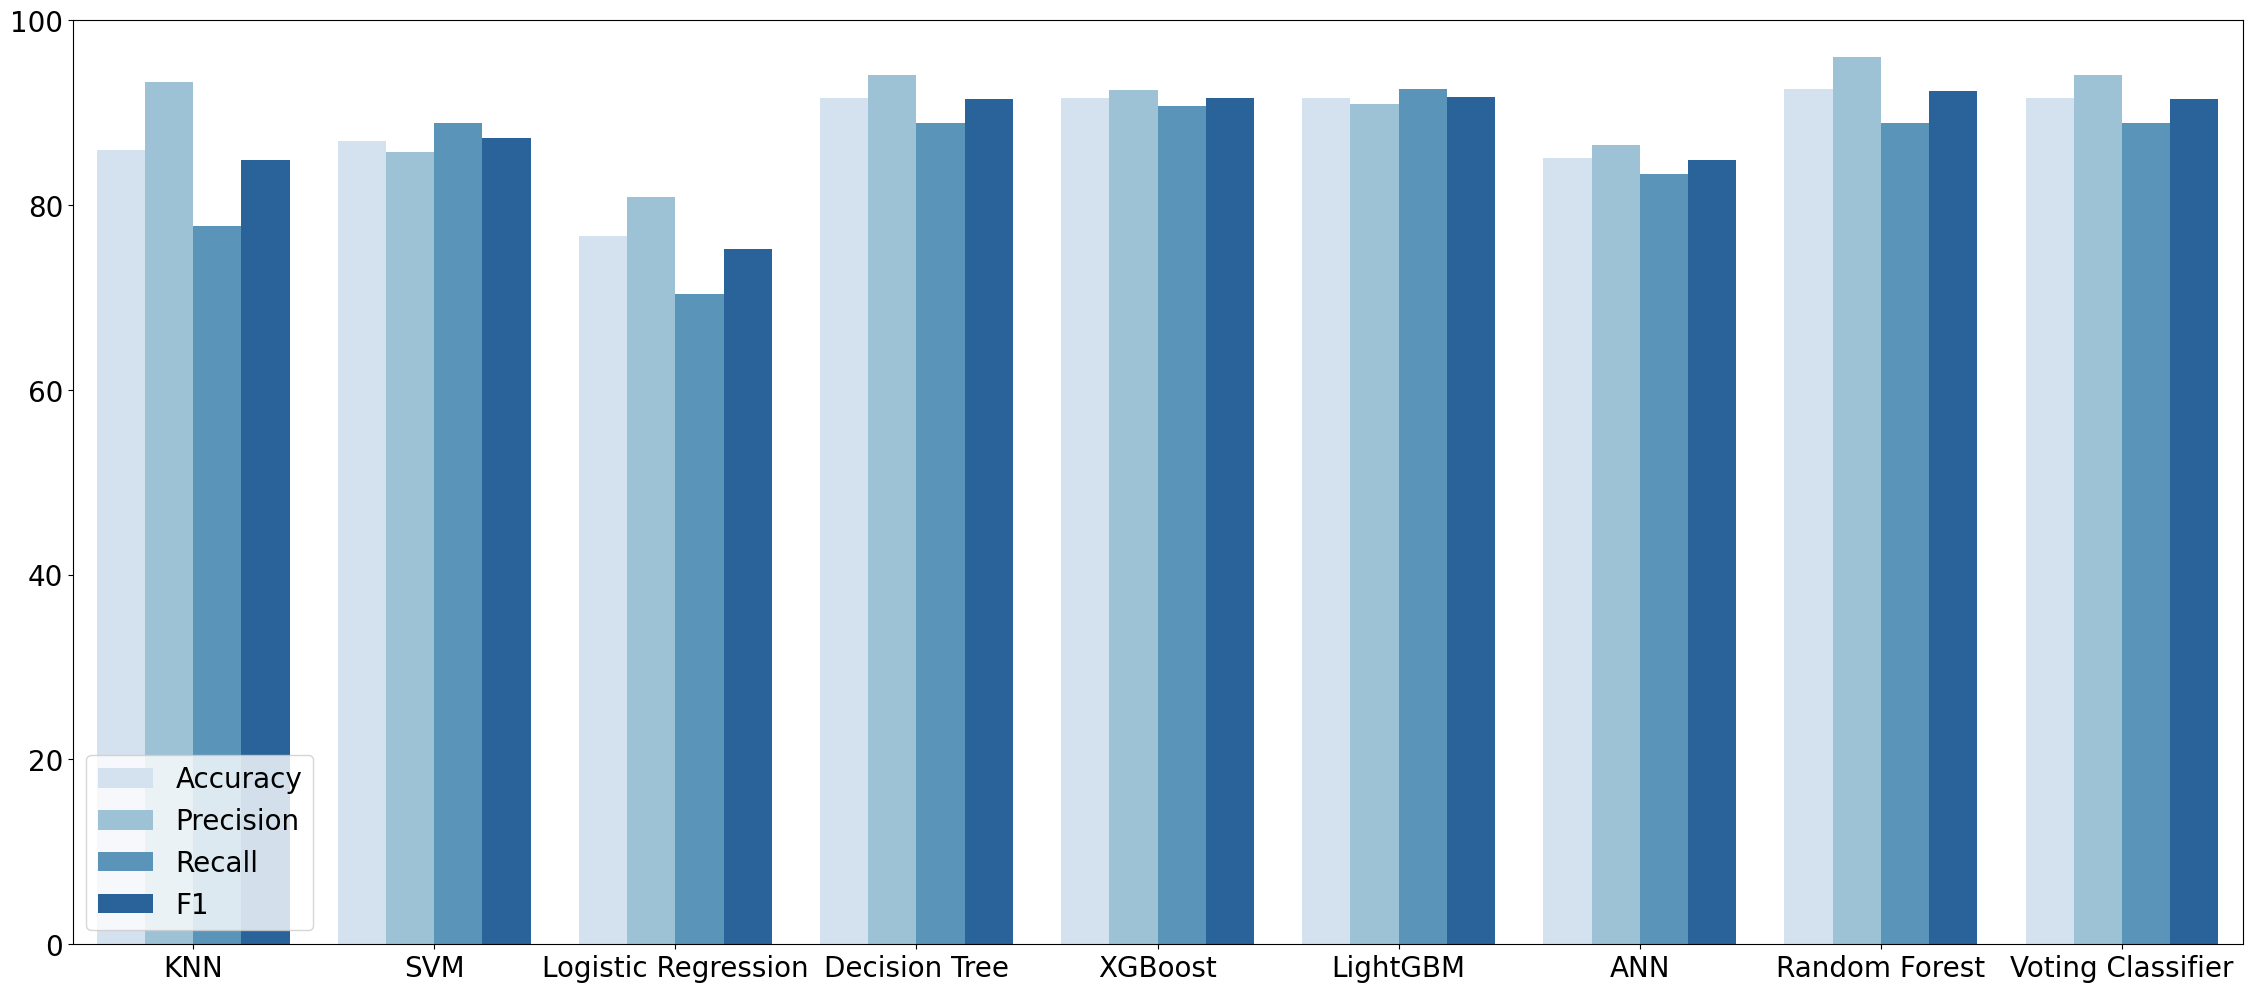

In [33]:
model_report = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

for initial in model_y_predict:
    accuracy = accuracy_score(model_y_true['value'], model_y_predict[initial]) * 100
    precision = precision_score(model_y_true['value'], model_y_predict[initial]) * 100
    recall = recall_score(model_y_true['value'], model_y_predict[initial]) * 100
    f1 = f1_score(model_y_true['value'], model_y_predict[initial]) * 100
    
    report = pd.DataFrame({'Model': [initial_model_name[initial]],
                           'Accuracy': [accuracy],
                           'Precision': [precision],
                           'Recall': [recall],
                           'F1': [f1]})
    
    model_report = pd.concat([model_report, report], axis=0, ignore_index=False)

display(model_report)

threshold = '17_5'

model_report.to_csv(f'Model_Report-{threshold}.csv', index=False)

model_report = pd.melt(model_report, id_vars=['Model'], var_name='Metric', value_name='Value')

plt.figure(figsize=(28, 12))
axis = sns.barplot(model_report, 
            x='Model', 
            y='Value', 
            hue='Metric', 
            palette=sns.color_palette('Blues', 4))

plt.ylim(0, 100)

axis.set(xlabel=None)
plt.xticks(fontsize=20)
axis.set(ylabel=None)
plt.yticks(fontsize=20)

plt.legend(loc='lower left', fontsize=20)

plt.savefig('model_report.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('model_report.png', dpi=600, bbox_inches='tight')

plt.show()

## Confusion Matrix

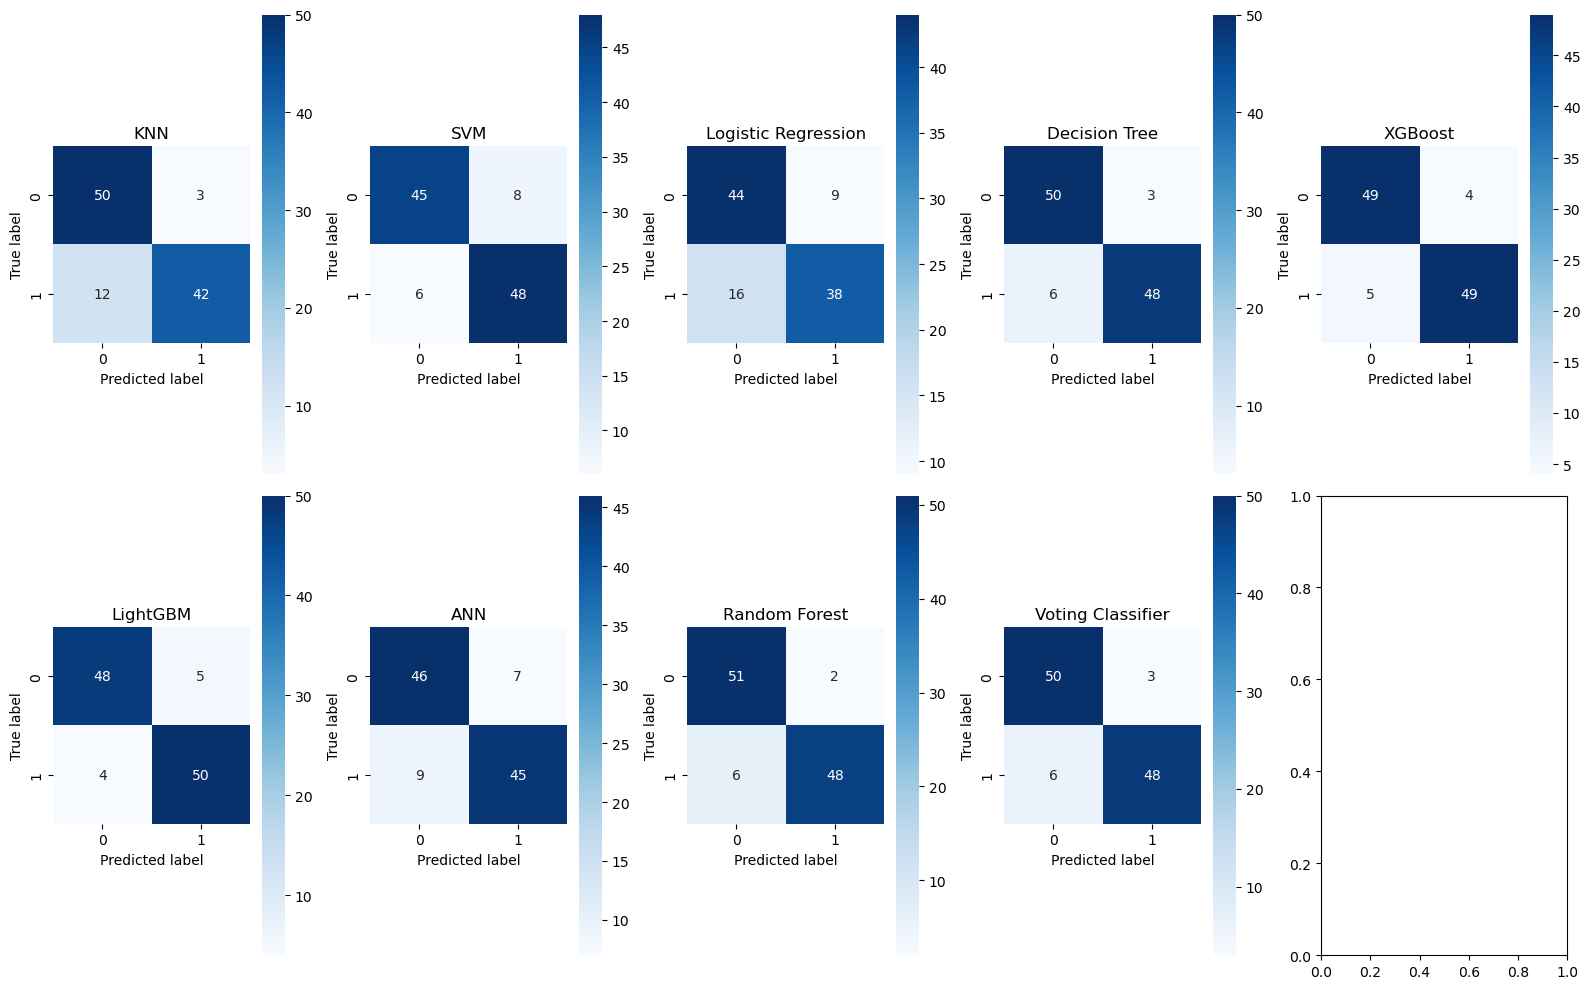

In [34]:
row, column = 2, 5
figure, axis = plt.subplots(nrows=row, ncols=column, figsize=(16, 10))

for i, initial in enumerate(model_y_predict):
    sns.heatmap(confusion_matrix(model_y_true['value'], 
                                 model_y_predict[initial]), 
                ax=axis.flat[i],
                cmap='Blues',
                square=True, 
                annot=True)
    axis.flat[i].set_title(initial_model_name[initial])
    axis.flat[i].set_xlabel('Predicted label')
    axis.flat[i].set_ylabel('True label')

figure.tight_layout()

plt.savefig('confusion_matrix.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('confusion_matrix.png', dpi=600, bbox_inches='tight')

plt.show()

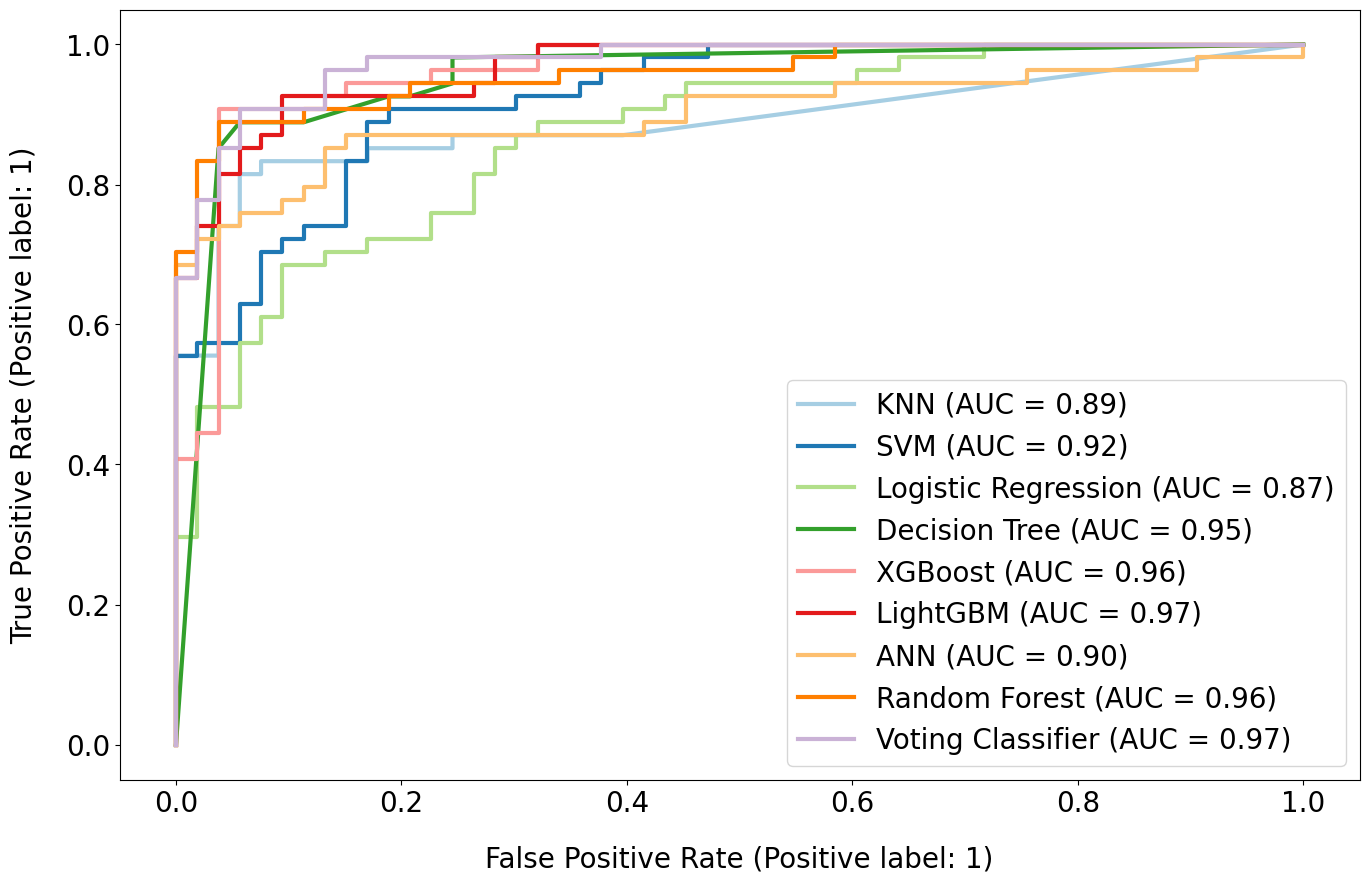

In [35]:
from matplotlib.colors import ListedColormap

color = sns.color_palette('Paired', 9)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

for i, initial in enumerate(model_y_predict):
    RocCurveDisplay.from_predictions(model_y_true['value'], 
                                     model_y_predict_score[initial], 
                                     color=color[i], 
                                     name=initial_model_name[initial], 
                                     linewidth=3, 
                                     ax=axis)

plt.xlabel('False Positive Rate (Positive label: 1)', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.ylabel('True Positive Rate (Positive label: 1)', fontsize=20, labelpad=20)
plt.yticks(fontsize=20)

plt.legend(loc='best', fontsize=20)

plt.savefig('roc.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('roc.png', dpi=600, bbox_inches='tight')

plt.show()

## SHAP Explaination

100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 114.62it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


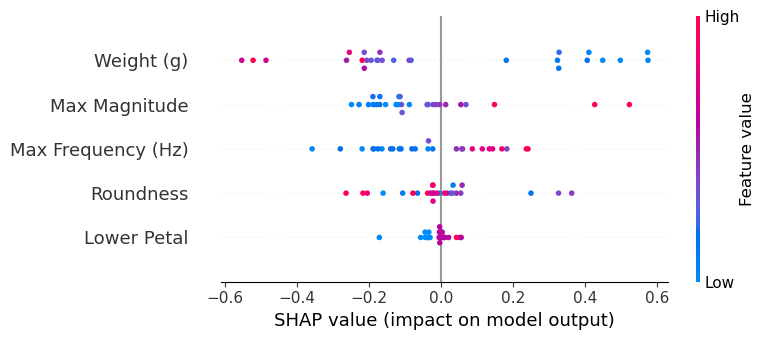

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature)
X_test = pd.DataFrame(X_test, columns=feature)

for initial, model in classifier:
    model.fit(X_train, y_train)

explainer = shap.KernelExplainer(ANN.predict_proba, X_train)
shap_value = explainer.shap_values(X_test)

shap.summary_plot(shap_value[1], X_test, show=False)

plt.savefig('shap.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('shap.png', dpi=600, bbox_inches='tight')

# Dependence Dataset Prediction

In [37]:
count_prediction = pd.DataFrame({'index': model_y_true['index'],
                                 'no': model_y_true['no'],
                                 'value': model_y_true['value']})

for initial in model_y_predict:
    count_prediction[initial] = model_y_predict[initial]

count_prediction['Prediction Rate'] = count_prediction.iloc[:, 3:].sum(axis=1) / len(classifier)

# display(count_prediction)

## True Prediction

In [38]:
positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
true_positive_prediction = positive_prediction[positive_prediction['value'] == 1]

print('Positive Class:', true_positive_prediction.shape)

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
true_negative_prediction = negative_prediction[negative_prediction['value'] == 0]

print('Negative Class:', true_negative_prediction.shape)

# display(false_negative_prediction)

true_prediction = pd.concat([true_positive_prediction, true_negative_prediction])

display(true_prediction)

print('Shape: ', true_prediction.shape)

# true_prediction.to_csv(f'TruePrediction-{int(num) + 1}.csv')

Positive Class: (48, 13)
Negative Class: (51, 13)


,index,no,value,KNN,SVM,LR,DT,XGB,LGBM,ANN,RF,VC,Prediction Rate
0,5.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
1,8.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
2,15.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
3,28.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
4,35.0,57.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,69.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
103,72.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.111111
104,83.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
105,92.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Shape:  (99, 13)


In [39]:
good_dataset = df.loc[true_prediction['index'].tolist(), :]

display(good_dataset)

if export_good_bad_dataset:
    good_dataset.to_csv(f'GoodDataset-{int(num) + 1}.csv', index=False)

,No,Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
5,NaN,46.294660,0.925,NaN,5,104.463849,45.273911,18.163731,1
8,16.0,50.470000,0.948,4.0,5,130.276327,59.920000,19.875000,1
15,24.0,51.480000,0.968,4.0,6,130.276327,72.980000,22.375000,1
28,NaN,48.098566,0.956,NaN,5,261.574882,36.529069,20.001388,1
35,57.0,61.530000,0.937,4.0,6,130.276327,82.980000,20.125000,1
...,...,...,...,...,...,...,...,...,...
69,NaN,56.240959,0.960,NaN,5,100.201709,17.677249,16.744483,0
72,NaN,58.190891,0.980,NaN,5,73.539477,12.407682,12.628383,0
83,143.0,57.840000,0.961,4.0,6,101.450000,29.990000,16.875000,0
92,NaN,73.984773,0.918,NaN,5,101.015961,27.689843,12.385958,0


## False Prediction

In [40]:
positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
false_positive_prediction = positive_prediction[positive_prediction['value'] == 0]

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
false_negative_prediction = negative_prediction[negative_prediction['value'] == 1]

# display(false_negative_prediction)

false_prediction = pd.concat([false_positive_prediction, false_negative_prediction])

display(false_prediction)

print('Shape: ', false_prediction.shape)

# false_prediction.to_csv(f'FalsePrediction-{int(num) + 1}.csv')

,index,no,value,KNN,SVM,LR,DT,XGB,LGBM,ANN,RF,VC,Prediction Rate
30,74.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.777778
76,98.0,39.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
24,10.0,83.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111
26,23.0,82.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111
46,26.0,41.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.333333
56,19.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.333333
57,24.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222
70,53.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222


Shape:  (8, 13)


In [41]:
bad_dataset = df.loc[false_prediction['index'].tolist(), :]

display(bad_dataset)

if export_good_bad_dataset:
    bad_dataset.to_csv(f'BadDataset-{int(num) + 1}.csv', index=False)

,No,Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
74,NaN,91.626010,0.934000,NaN,7,173.413031,44.155590,13.499212,0
98,39.0,83.240000,0.947427,4.0,7,173.940000,53.830000,16.500000,0
10,83.0,65.240000,0.952000,4.0,4,135.170000,25.400000,17.500000,1
23,82.0,65.190000,0.970000,4.0,7,164.240000,27.190000,17.625000,1
26,41.0,76.890000,0.928000,4.0,6,130.276327,34.210000,20.750000,1
19,NaN,60.810064,0.977000,NaN,6,130.709523,42.458858,17.572535,1
24,NaN,52.738732,0.936000,NaN,5,75.284190,28.947813,19.774838,1
53,NaN,55.231097,0.972000,NaN,7,133.285048,19.876806,19.096350,1
